# OpenStreetMap notebook

Uses GeoPandas, osmnx, Leaflet to load and render geo-spatial info

Shapely used for "planar geometric objects" (used internally by GeoPandas)

GeoPandas docs: https://geopandas.org/en/stable/docs.html
osmnx docs: https://osmnx.readthedocs.io/en/stable/index.html
OpenStreetMap: https://www.openstreetmap.org

Shapely: https://shapely.readthedocs.io/en/stable/index.html

## Mini OSMnx plotting test

Testing a plot from a place

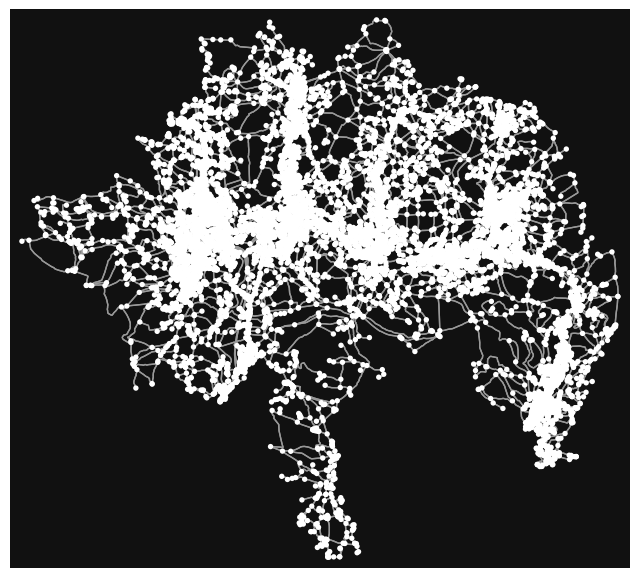

In [1]:
import networkx as nx
import osmnx as ox

ox.__version__
G = ox.graph.graph_from_place("Rossendale, Lancashire, United Kingdom", network_type="walk")
fig, ax = ox.plot.plot_graph(G)

## Encoding and GeoPandas trial

Strava uses Google Polyline Encoding - https://developers.google.com/maps/documentation/utilities/polylinealgorithm

This decodes the string, and compares the nodes using geopandas

NB: here the route is an "out-and-back" so the first and last points will be very close to each other

Google polyline coordinates are (lat, lng) but GeoJSON expects (lng, lat)
TODO: remove uk_map and avoid confusion

## WIP - Local .graphml files

osmnx uses the Overpass API for OpenStreetMaps

This is a try at saving some local nodes as .graphml and avoid any heavy calls to the API

Unfortunately didn't end up using it

In [ ]:
import networkx as nx
import osmnx as ox

file_path = "./osm/lancashire.graphml"
place = "Lancashire, United Kingdom"

'''
Gets a Graph for Lancashire, as a way to use local data 
'''

# get a graph, set 'w3' edge attribute
G = ox.graph_from_place(place, network_type='walk')
nx.set_edge_attributes(G, 100, 'w3')

# save graph to disk
ox.save_graphml(G, file_path)

# load graph from disk and confirm 'w3' edge attribute is there
G2 = ox.load_graphml(file_path)
nx.get_edge_attributes(G2, 'w3')

## Making use of .geojson

Converting the polyline string to .geojson file

Similar to above block except here we also convert to .geojson

Outputs as 'EPSG:4326', since it's the most common GeoPandas format

In [3]:
import polyline
import geopandas as gpd
from shapely.geometry import LineString
import os

# Coordinate Reference Systems
CRS_WGS84 = 'EPSG:4326'      # Geographic (lat/lng degrees)
CRS_WEB_MERCATOR = 'EPSG:3857'  # Projected (Google Maps meters)

def decode_google_polyline(encoded_str: str) -> list[tuple[float, float]]:
    """Decode Google polyline string to WGS84 coordinates"""
    return polyline.decode(encoded_str)

def create_web_mercator_gdf(coords: list[tuple[float, float]]) -> gpd.GeoDataFrame:
    """Create GeoDataFrame in Web Mercator projection"""
    # Google polyline coordinates are (lat, lng) in WGS84
    # Convert to (lng, lat) for proper Web Mercator handling
    geometry = LineString([(lng, lat) for lat, lng in coords])
    return gpd.GeoDataFrame(geometry=[geometry], crs=CRS_WGS84).to_crs(CRS_WEB_MERCATOR)

def convert_to_wgs84(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Convert GeoDataFrame to WGS84 geographic CRS"""
    return gdf.to_crs(CRS_WGS84)

def save_geojson(gdf: gpd.GeoDataFrame, output_dir: str, filename: str) -> None:
    """Save GeoDataFrame to GeoJSON file"""
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{filename}.geojson")
    gdf.to_file(output_path, driver="GeoJSON")
    print(f"GeoJSON saved to {output_path}")

def process_activity_data(encoded_polyline: str, output_dir: str, activity_name: str) -> None:
    """End-to-end processing pipeline for activity data"""
    # 1. Decode polyline to WGS84 coordinates
    wgs84_coords = decode_google_polyline(encoded_polyline)
    
    # 2. Create and validate Web Mercator geometry
    web_mercator_gdf = create_web_mercator_gdf(wgs84_coords)
    
    # 3. Convert to standard WGS84 for GeoJSON
    wgs84_gdf = convert_to_wgs84(web_mercator_gdf)
    
    # 4. Save final GeoJSON
    save_geojson(wgs84_gdf, output_dir, activity_name)

# Example usage
if __name__ == "__main__":
    test_polyline = "sa_gIprxLDSM_AFmAI_@]s@I@CoA]sAFO?c@MYQIEg@Wg@CcB_@cDQy@@a@[u@EY?_@]aDBc@KS?gAQuAeAqC]yCi@gCe@q@Gq@Qq@GBK]ICQw@OMe@}@Sq@g@cAg@uAOiAYm@CUOOEg@UGmAcFMQa@KWi@D@Kg@Jw@?[cBoL}ByMaBeI_@qDFa@KUEu@Ka@_@i@q@s@}@s@}@_F]sASiHDMOyB@s@_@oH@kCd@cDPcBlCwPDi@EY`@Uf@ETg@NcAbACLQD]ROPJZ`AL}@p@h@p@Ml@g@f@GZtB?|@NnB?`BLj@?d@NxA\\tAA|@Mr@Nd@n@z@Tn@`@VEEv@}@jAy@zA~EzBnC~B~BrA~CzAzCf@pAv@lAxBrBnCvC`ArAp@`@hApAhGlFfAd@|@FzFJ|AI|BtAf@x@Rn@|BhJb@t@tAnAbBNbAgAbCuA~Fg@l@Nx@n@x@Tb@l@rAz@jBhBXJd@t@pDfCT@^^|DhBpClBvIpDb@JnFvCtCbAVAPj@P`BA`AZfB\\N`@z@^\\~At@xA^r@n@hAVd@Df@Gl@_@rAa@jAN~CrBj@~@t@fBXz@f@f@hCLz@GpJ{Bp@Dx@ODHAVk@KsAJa@JWX}Bv@qBLwATYPMKWLgBY}@_AM_AqAwCWYm@Se@o@}Am@kBXqAr@g@BuAc@y@w@kDmAs@s@u@mBg@kEUeASQ}AYeAc@YNUGUP_Aq@iBc@EEFq@CG}Ag@kAu@uAs@YBkAk@IOiCy@_Aw@KWq@Y}AiAa@COWwAq@k@c@]e@s@_@g@q@_FqD_Bm@e@ASUi@AyEd@oAj@eBrAi@Pu@CwAo@w@kA@k@yB{J_AsAkAs@a@I_KUoAYk@a@qEiEuA_AwCsCQ_@qDoDy@iAkB_EaA_BcAcCk@u@}D}Dq@sAoA{E{@wG}@mJq@{D}@cDqA_Dm@qBy@eC]s@S\\FlCKp@oAdBwDjGqBtCDVLLd@xBoBhMu@hGKRCv@WrAAt@H|C\\vGHpEH`B@vBZhAx@`E@d@z@`@TRjAlBDpAJ^LlChBxIv@fE|CxSLjBSXUYqBc@sBaAAKo@c@SA{A}@{ALaAc@kACwAa@cAs@mAc@SYsCj@oAh@g@b@eAnA"
    
    process_activity_data(
        encoded_polyline=test_polyline,
        output_dir="./out/osm",
        activity_name="activity"
    )

GeoJSON saved to ./out/osm/activity.geojson


## Read .geojson and plot in OpenStreetMap

Now we have an activity.geojson lets try to overlay in OpenStreetMap

Will:
- read route .geojson 
- load inside GeoPandas
- load OpenStreetMap road network
- create a Leaflet map with route, osm network, start / end

Meant to show both the Strava activity in OSM

Whilst also showing roads nearby, as a recommendation feature

Contain heavy optimisations for overpass:
- custom memory
- custom max_query_area_size
- cache usage
- increased timeouts
- polygon network fetching, with buffered / simplified points

In [6]:
import geopandas as gpd
import osmnx as ox
import folium
from shapely.geometry import Polygon, LineString
import time

activity_path = "./out/osm/activity.geojson"
out_map = "./out/osm/route_map.html"
crs_geo = 'EPSG:4326'  # WGS84 for geographic operations
crs_gmaps = 'EPSG:3857'  # Google Maps, Mercator


# Configure OSMnx settings
ox.settings.max_query_area_size = 30000  # Set to 50 km² (default is 25 km²)
ox.settings.timeout = 120  # Increase timeout to 2 minutes, 60 sec base
ox.settings.log_console = True
ox.settings.use_cache = True
ox.settings.overpass_memoryint = 1000000 # 1Mb in Bytes
ox.settings.max_query_area_size = 2500000000 * 3

def read_geojson(geojson_path: str) -> gpd.GeoDataFrame:
    """Read and validate GeoJSON with WGS84 coordinates"""
    gdf = gpd.read_file(geojson_path)
    if gdf.crs != crs_geo:
        raise ValueError(f"Expected WGS84 (EPSG:4326) coordinates, got {gdf.crs}")
    return gdf

def calculate_query_polygon(geometry: gpd.GeoSeries, buffer_meters: int = 10) -> Polygon:
    """Create query polygon around Manchester area coordinates"""
    # Get base geometry (already in WGS84)
    geom = geometry.iloc[0]
    
    # Validate coordinates are in Greater Manchester area
    min_lon, min_lat, max_lon, max_lat = geom.bounds
    if not (-2.5 <= min_lon <= -2.0 and 53.4 <= min_lat <= 53.8):
        raise ValueError(f"Coordinates outside Manchester area: {geom.bounds}")
    
    # Create buffer in degrees (500m ≈ 0.0045°)
    return geom.buffer(0.0045)

def get_osm_data_v1(polygon: Polygon) -> tuple:
    """Robust OSM data fetcher with multiple fallback strategies."""
    validate_coordinates(polygon)
    max_retries = 5

    strategies = [
        {'network_type': 'walk', 'simplify': True},
        {'network_type': 'all', 'simplify': True},
        {'custom_filter': '["highway"]["area"!~"yes"]'}
    ]

    for attempt in range(max_retries):
        for strategy in strategies:
            try:
                print(f"Attempt {attempt+1} with strategy: {strategy}")
                G = ox.graph_from_polygon(
                    polygon,
                    **strategy,
                    truncate_by_edge=True
                )
                
                if len(G.nodes) > 0 and len(G.edges) > 0:
                    return ox.graph_to_gdfs(G)
                
            except Exception as e:
                print(f"Strategy failed: {str(e)}")
                time.sleep(5 ** (attempt + 1))  # Exponential backoff
        
        # Progressive area reduction
        reduced_poly = polygon.buffer(-0.01 * (attempt + 1))
        if reduced_poly.is_empty:
            break
        polygon = reduced_poly

    raise RuntimeError("All data fetch strategies failed")

def get_osm_data_v2(polygon: Polygon):
    """Fetch OSM data for Manchester area"""
    print(f"Querying area: {polygon.bounds}")
    return ox.graph_from_polygon(
        polygon,
        network_type="walk",
        simplify=True
    )


def create_map(route_gdf: gpd.GeoDataFrame, G=None) -> folium.Map:
    """Create Folium map with optimized overlay handling."""
    try:
        """Create Folium map with OSM graph and route."""
        # Convert route coordinates to (lat, lon)
        route_coords = [(y, x) for x, y in route_gdf.geometry.iloc[0].coords]
        
        # Create base map centered on route
        centroid = [sum(y for y, _ in route_coords)/len(route_coords),
                    sum(x for _, x in route_coords)/len(route_coords)]
        m = folium.Map(location=centroid, zoom_start=14, tiles="CartoDB positron")
    
        # Add OSM graph edges if available
        if G is not None:
            for _, edge in ox.graph_to_gdfs(G, nodes=False).iterrows():
                line = edge.geometry
                if isinstance(line, LineString):
                    folium.PolyLine(
                        [(y, x) for x, y in line.coords],
                        color="#336699",
                        weight=2.0,    
                        opacity=0.9 
                    ).add_to(m)
    
        # Add activity route
        folium.PolyLine(
            route_coords,
            color="#ff0000",
            weight=3,
            opacity=0.9,
            tooltip="Activity Route"
        ).add_to(m)

        # Add optimized markers
        if len(route_coords) > 0:
            folium.Marker(
                route_coords[0], 
                icon=folium.Icon(color="green")
            ).add_to(m)
            
        if len(route_coords) > 1:
            folium.Marker(
                route_coords[-1], 
                icon=folium.Icon(color="blue")
            ).add_to(m)

        return m

    except Exception as e:
        raise RuntimeError(f"Map creation failed: {str(e)}") from e

def main():
    """Optimized main workflow execution."""
    try:
        # Load and validate data
        gdf = read_geojson(activity_path)
        route_geom = gdf.geometry
        
        # Create optimized query polygon
        query_poly = calculate_query_polygon(route_geom)
        
        # Get OSM data
        G = get_osm_data_v2(query_poly)
        m = create_map(route_geom, G)
        m.save(out_map)
        print(f"Map successfully saved to {out_map}")
        display(m);
        
    except Exception as e:
        print(f"Error: {str(e)}")
        if "max_query_area_size" in str(e):
            print("Consider: 1) Reducing buffer size 2) Processing in smaller segments")
        raise

if __name__ == "__main__":
    main()

Querying area: (-2.2655499788282825, 53.70650097205358, -2.2180405744490677, 53.75535775248755)
Map successfully saved to ./out/osm/route_map.html
